In [1]:
from grad import *
import numpy as np
import math

In [4]:
def l2_loss(truth, model):
    ''' Simple L2 loss for a single sample.
    
        Parameters
        ----------
        truth : Sequence[float]
            A single data point.
              
        model : Sequence[float]
            The parameters of a model.
              
        Returns
        -------
        Number : the L2 loss (squared error) of `model_params` evaluated on `truth`
    '''
    l = truth[0] - model[0] - sum(truth[i]*model[i] for i in range(1, len(model)))
    return l**2 if l.data > 0 else (-1*l)**2

In [5]:
def topo_sort(N):
    '''Returns the correct order to backprop N in. Yes. This is such that if you call backprop(N), the gradient on N is final.
    rets a list of Numbers.
    
    So ideally we'd just backprop one layer (to N's two creators (ie a and b when u backprop N in a * b = N) when we get to the N 

    *sigh* back to the usaco grind
    '''
    ret = []
    visited = {}
    def dfs(number):
        '''
        dfs's a Number, following it down the path by df'sing its two creators.
        '''
        if visited.get(number)== "visited":
            return True
        if visited.get(number) == "visiting":
            return False
        visited[number] = "visiting"
        
        if number.creator != None:
            if not dfs(number.creator.a):
                print(number, " to " , number.creator.a)
            if not dfs(number.creator.b):
                print(number, " to " , number.creator.b)
        visited[number] = "visited"
        ret.append(number)
        return True
        
    dfs(N)
    ret.reverse()
    return ret


In [106]:
np.random.seed(0)

def weight_matrix(shape, naive=False):
    """weight matrix thingy.give dims. Not 0."""
    # np.as_array(Number(np.random.rand()) for i in range(M*N))
    number = 1
    if(type(shape) == int):
        shape = [shape]
    for i in shape:
        number*= i
    if naive:
        return np.array([Number(i / 10) for i in range(number)]).reshape(*shape)
    return np.array([Number(np.random.uniform(low=-.2, high=.2, size=None)) for i in range(number)]).reshape(*shape)
 
def get_grads(x):
    vectorized_grad = np.vectorize(lambda x : x.grad) #not true vecotrization just for readibility
    return vectorized_grad(x)

def sigmoid(x):
    return np.vectorize(lambda x: 1/(1+math.e**-x))(x)

def relu(x):
    # print(x)
    def relu_one(k):
        if k <= 0:
            return 10e-2 * k
        else:
            return k
    return np.vectorize(lambda x: relu_one(x))(x)

In [270]:
class Model():
    '''this only works w/ MSE and sigmoid because dik how to topological sort'''
    
    def __init__(self, input_size, output_size, hidden_layers, naive=False):
        '''
        Takes list of # of things in their layers.
        Layers are outputs?
        '''
        self.layer_sizes = hidden_layers
        self.layers = []
        self.biases = []

        #Hidden states is after the *weight but before sigmoid
        self.hidden_states = []

        self.hidden_states_sigmoid = []
        
        prev = input_size
        for hidden_layer in hidden_layers:
            # self.layers, weight_matrix([prev, hidden_layer])
            self.layers.append(weight_matrix([prev, hidden_layer], naive))

            self.biases.append(weight_matrix(hidden_layer, naive))
            prev  = hidden_layer
        self.biases.append(weight_matrix([output_size]))
        self.layers.append(weight_matrix([prev, output_size]))
  
    def fd(self, x):
        '''f pass with input. Input has to be flat like a pancake'''
        #sigma sigma boy.
        self.hidden_states_sigmoid = []
        self.hidden_states = []
        self.input = x
        for i in range(len(self.layers)):
            # print(np.max(x))
            x = x @ self.layers[i]
            x += self.biases[i]
            self.hidden_states.append(x)
            if i != len(self.layers) - 1:
                x = relu(x)
                # print("Non-zero ReLUs:", np.count_nonzero(x))
            else:
                x = sigmoid(x)
            self.hidden_states_sigmoid.append(x)

        return x
        
    def train_epoch(self, x, y, lr=10**-2):
        '''
        f pass and then uh gradient descent?

        x: Input. Again, flat as a pancake.
        y: the goal. In sparese tensor. 
        lr: how quick it learns
        '''
        num_correct = 0
        losses = []
        for i in range(len(y)):
        #     for layer in self.layers:
        #         for w in layer.flat:
        #             w.null_gradients(recursive=False)

        #     for bias in self.biases:
        #         for b in bias.flat:
        #             b.null_gradients(recursive=False)
                    
            pred = self.fd(x[i])
            # mse = np.sum((pred * pred +  y[i] *  y[i] - 2 * np.dot(pred, y[i]))) / len(y)
            mse = sum((a - b)**2 for a, b in zip(pred, y[i]))

            num_correct += np.argmax(pred) == np.argmax(y[i])
            losses.append(mse)
            mse_sorted = topo_sort(mse)
            # print(f"order {mse_sorted}")
            for num in mse_sorted:
                num.backprop_single()
            # print("Final layer pre-sigmoid:", self.hidden_states[-1])

            #These look ok.
            # for i, layer in enumerate(self.layers):
            #     for j, num in enumerate(layer.flat):
            #         print(f"Layer {i} Flat[{j}] grad: {num.grad}")
            #     for m, r in enumerate(layer):
            #         for n, c in enumerate(r):
            #             print(f"Layer {i} Row {m} col {n} grad: {c.grad}")
            # self.print_info()
            
            #What in the FREAK is nulling the gradients here?????
            for i, layer in enumerate(self.layers):
                for w in range(len(layer.flat)):
                    layer.flat[w] = Number(layer.flat[w] - layer.flat[w].grad * lr)
            #OH WAIT IT SHOULD BE NULL :sob: WE MAKING NEW NUMBERS. Cleans the graph too!
            # self.print_info()

            for i in range(len(self.biases)):
                layer = self.biases[i]
                for b in range(len(layer.flat)):
                    layer.flat[b] = Number( layer.flat[b] - layer.flat[b].grad * lr)
        print(f"Acc: {num_correct/len(y)} Avg loss: {sum(losses)/len(y)}")
            # print(f"Acc: {num_correct/len(y)} Avg loss: {losses}")

    def print_info(self, verbose=True):
        print("layers " )
        for i in range(len(self.layers)):
            print( f"weight {i} of shape {self.layers[i].shape}")
            print(self.layers[i])
            print("grads")
            print(np.vectorize(lambda x : x.grad)(self.layers[i]))
            
        print("biases ")
        for i in range(len(self.biases)):
            print( f"bias {i} of shape {self.biases[i].shape}")
            print(self.biases[i])

In [272]:
tiny_x = [[1, 2], [2, 3]]
tiny_test = Model(2, 2, [3, 1], naive=True)
tiny_test.train_epoch(tiny_x, np.array( [[0, 1],[1, 0]]))


Acc: 0.5 Avg loss: Number(0.5046219601608408)


Acc: 0.13 Avg loss: Number(1.291816224337269)
Acc: 0.09 Avg loss: Number(0.922030117375282)
Acc: 0.11 Avg loss: Number(0.9167681954888175)
Acc: 0.11 Avg loss: Number(0.9131554217750134)
Acc: 0.1 Avg loss: Number(0.9105261004876037)
Acc: 0.1 Avg loss: Number(0.9084750528802458)
Acc: 0.1 Avg loss: Number(0.9067768847705626)
Acc: 0.11 Avg loss: Number(0.905306783956894)
Acc: 0.12 Avg loss: Number(0.9039868066098039)
Acc: 0.12 Avg loss: Number(0.9027607426123027)
Acc: 0.13 Avg loss: Number(0.9015819329495318)
Acc: 0.16 Avg loss: Number(0.9004054453628426)
Acc: 0.19 Avg loss: Number(0.8991802753332253)
Acc: 0.19 Avg loss: Number(0.8978373834696436)
Acc: 0.19 Avg loss: Number(0.8962646341611017)
Acc: 0.21 Avg loss: Number(0.8942399105721449)


KeyboardInterrupt: 

In [302]:
fake = np.array([Number(i/10 + 1) for i in range(2)])
fake1 = np.array([Number(i/10 + .3) for i in range(2)]).reshape(2,1)
fake_bias = np.array([Number(i/10 + 2) for i in range(1)])

print("k1" , fake)
print("k2" , fake1)
print("kb" , fake_bias)

final1 = fake @ fake1 
final = final1 + fake_bias
print("f1" , final1)

print("f" , final)

idk = topo_sort(final[0])
print(idk)
for num in final1.flat:
    print("a" , num,num.creator, num.creator.a, num.creator.b)

for num in final:
    
    num.backprop_single()



k1 [Number(1.0) Number(1.1)]
k2 [[Number(0.3)]
 [Number(0.4)]]
kb [Number(2.0)]
f1 [Number(0.74)]
f [Number(2.74)]
[Number(2.74), Number(2.0), Number(0.74), Number(0.44000000000000006), Number(0.4), Number(1.1), Number(0.3), Number(0.3), Number(1.0)]
a Number(0.74) + Number(0.3) Number(0.44000000000000006)


In [ ]:
tiny_x = [[1, 2, 3, 4]]
tiny_test = Model(4, 1, [3], naive=True)
tiny_test.print_info()
tiny_test.train_epoch(tiny_x, np.array([2,3]))
tiny_test.train_epoch(tiny_x, np.array([2,3]))

In [10]:
def null_gradients(layers):
    """nulls all gradients"""
    for layer in layers:
        for weight in layer.flat:
            weight.null_gradients()
            
def check_null(layers):
    """nulls all gradients"""
    for layer in layers:
        for weight in layer.flat:
            if weight.grad != None:
                print("hi welcome to another 5hrs of debuggin")
    print("passed null check ")



In [11]:
def fix_data(x, y):
    x = x.reshape(x.shape[0], 28*28)/255
    test = np.zeros((x.shape[0], 10))
    test[np.arange(x.shape[0]),y] = 1
    return (x, test)

In [285]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")
testx, testy = fix_data(x_train[0:2], y_train[0:2])
rawx = x_train[0:2]



[5 0 4 ... 5 6 8]


In [289]:
fixed_x, fixed_y = fix_data(x_train[:1000], y_train[:1000])

In [293]:
#Moment of truth
plswork = Model(28*28, 10, [4, 8])
for i in range(100):
    plswork.train_epoch(fixed_x, fixed_y, lr=10e-2)

Acc: 0.193 Avg loss: Number(0.9148206999012773)
Acc: 0.347 Avg loss: Number(0.7649153700637776)
Acc: 0.417 Avg loss: Number(0.7048005599121263)
Acc: 0.476 Avg loss: Number(0.659013730140775)
Acc: 0.556 Avg loss: Number(0.6126583948084633)
Acc: 0.619 Avg loss: Number(0.5233582602451018)
Acc: 0.681 Avg loss: Number(0.4554136677357978)
Acc: 0.7 Avg loss: Number(0.41836248180804436)
Acc: 0.721 Avg loss: Number(0.40502758578499515)
Acc: 0.722 Avg loss: Number(0.40834967394121585)
Acc: 0.741 Avg loss: Number(0.3860735134187396)
Acc: 0.757 Avg loss: Number(0.3879122382040642)
Acc: 0.644 Avg loss: Number(0.5298185450036147)


KeyboardInterrupt: 

# still in shock that it actually works 

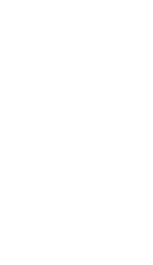

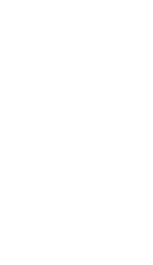

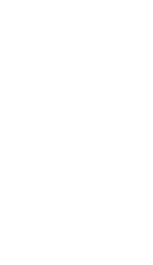

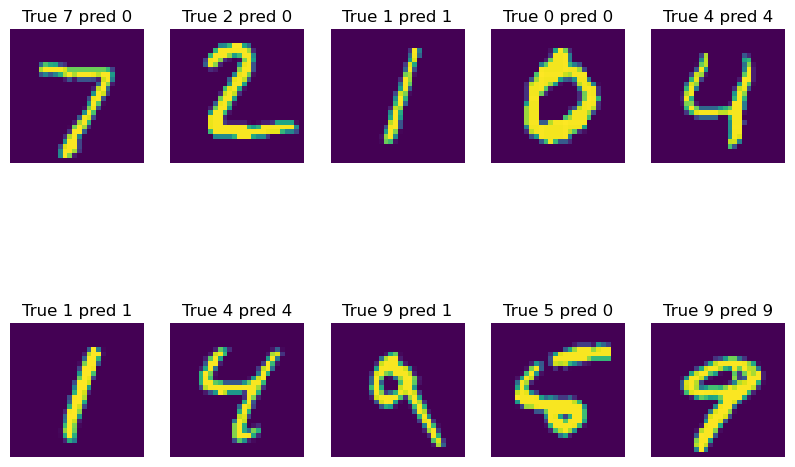

In [316]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

fig = plt.figure(figsize=(10, 7))
pic = 1
for i, img in enumerate(x_test[:10]):
  plt.subplot(2, 5, pic)
  plt.axis('off')
  predicted = plswork.fd(img.flat)
  plt.title(f"True {y_test[i]} pred {np.argmax(predicted)}")
  plt.imshow(img)
  pic+= 1
plt.show()
#60% acc. Considering this is from nearly scratch not terrible 

# What I learned (future me pls remember this):
- Early gradients are kinda random. Don't print out the losses after every single image and then spend get sad when its not decreasing right. Even if it's working, only the after 1 epoch will show decreasing trend.
- Number class: w-= w.grad kind of created new Numbers, each of which had gradient = to None. This sent me on a wild goose chase debugging why gradients were fine before w-=w.grad and then None after for a long while.
- As another side note, no need to null the gradients if I re-make the graph from scratch (and better not to so that the old weights' states aren't remembered/backproped)
- The activation fxn Sigmoid goes at the end (not between layers. Otherwise the gradient gets really small and goes poof)
- Weights should also be p small unless I want overflow
- Topological sort might have a scary name but it was much easier/cleaner than trying to do it the other way. Moral of the story: scary name is not that bad